# Live Web Scraping & Word Cloud Generator

## 📋 Task Overview
This notebook demonstrates **real-time web scraping** and **text visualization** using Python. The goal is to:

1. **Extract headlines/text** from live websites
2. **Clean and process** the scraped content
3. **Generate visual word clouds** to identify trending topics and themes
4. **Handle errors gracefully** for robust scraping

## 🔧 Solution Architecture

### Core Components:
- **`simple_scrape_headlines()`** - Flexible web scraper with error handling
- **`clean_text_list()`** - Text preprocessing and stopword filtering  
- **`make_wordcloud()`** - Visual word cloud generation

### Key Features:
- ✅ **Robust Error Handling** - Handles timeouts, connection errors, HTTP errors
- ✅ **Flexible Targeting** - Supports custom CSS selectors or automatic tag detection
- ✅ **Smart Text Cleaning** - Removes URLs, special characters, and stopwords
- ✅ **Visual Feedback** - Progress updates and extraction statistics
- ✅ **Configurable Parameters** - Timeout, max items, custom stopwords

### Technologies Used:
- **`requests`** - HTTP requests and web scraping
- **`BeautifulSoup`** - HTML parsing and element extraction
- **`WordCloud`** - Word cloud visualization
- **`matplotlib`** - Plotting and display
- **`nltk`** - Natural language processing and stopwords
- **`re`** - Regular expressions for text cleaning

## 🎯 Use Cases
- **News Trend Analysis** - Monitor trending topics across news sites
- **Content Research** - Analyze themes from multiple sources
- **Social Media Insights** - Extract popular discussions
- **Market Research** - Track industry conversations
- **Educational Analysis** - Study content patterns

## 🚀 Quick Start
1. Run the installation cell to install required packages
2. Execute the main scraping cell to see TechCrunch analysis
3. Try different websites using the example cells below
4. Customize parameters for your specific needs

https://news.ycombinator.com/
 (Hacker News front page — headlines)

https://www.bbc.com/news
 (BBC News front page headlines) — prefer /rss or APIs if heavy scraping

https://en.wikipedia.org/wiki/Machine_learning
 (section titles & lead paragraph)

https://techcrunch.com/
 (tech headlines)

In [7]:
%pip install requests beautifulsoup4 wordcloud matplotlib nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\hmeln\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


=== Live Web Scraping and Word Cloud Generation ===

Fetching content from: https://nofluffjobs.com/ua
Successfully fetched page (status: 200)
Extracted 78 unique headlines/texts

Sample items (first 10):
 1. Тут знайдеш нову роботу.Перевір заробітки і аплікуй.
 2. Вакансії дня
 3. All offers
 4. Найпопулярніші
 5. Senior/Lead Full-Stack Developer
 6. Customer Support Specialist
 7. Java DeveloperНОВЕ
 8. Senior Data Scientist (Renewable Trading Systems)НОВЕ
 9. Sales ManagerНОВЕ
10. HR People Partner/HR ManagerНОВЕ
Cleaned text contains 168 words
Successfully fetched page (status: 200)
Extracted 78 unique headlines/texts

Sample items (first 10):
 1. Тут знайдеш нову роботу.Перевір заробітки і аплікуй.
 2. Вакансії дня
 3. All offers
 4. Найпопулярніші
 5. Senior/Lead Full-Stack Developer
 6. Customer Support Specialist
 7. Java DeveloperНОВЕ
 8. Senior Data Scientist (Renewable Trading Systems)НОВЕ
 9. Sales ManagerНОВЕ
10. HR People Partner/HR ManagerНОВЕ
Cleaned text contains 168 w

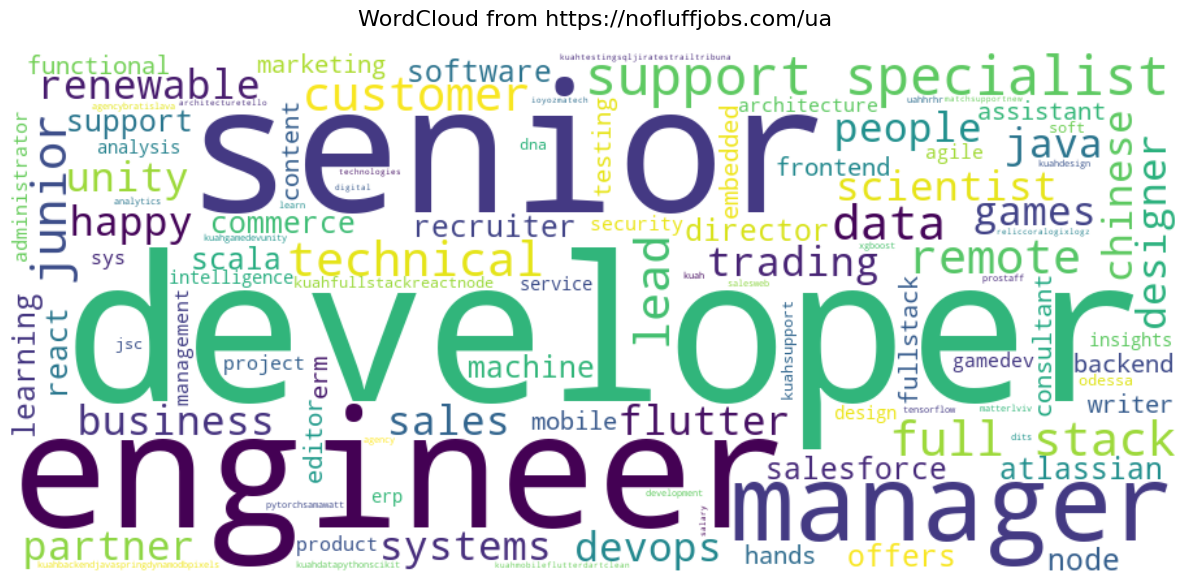

In [4]:
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
import nltk
import time

# Download NLTK stopwords (run once)
try:
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
except Exception as e:
    print(f"Warning: Could not download NLTK stopwords: {e}")
    print("Using basic English stopwords instead")
    stopwords = None

def simple_scrape_headlines(url, selector=None, max_items=50, timeout=10):
    """
    Simple headline scraper:
    - url: page to fetch
    - selector: optional CSS selector for headlines (if None we try common tags)
    - max_items: limit number of extracted items
    - timeout: request timeout in seconds
    Returns: list of strings (titles / snippets)
    """
    headers = {'User-Agent': 'Mozilla/5.0 (compatible; DemoBot/1.0)'}
    
    try:
        print(f"Fetching content from: {url}")
        resp = requests.get(url, headers=headers, timeout=timeout)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, 'html.parser')
        print(f"Successfully fetched page (status: {resp.status_code})")
        
    except requests.exceptions.Timeout:
        print(f"Error: Request timed out after {timeout} seconds")
        return []
    except requests.exceptions.ConnectionError:
        print("Error: Could not connect to the website. Check your internet connection.")
        return []
    except requests.exceptions.HTTPError as e:
        print(f"Error: HTTP error occurred: {e}")
        return []
    except Exception as e:
        print(f"Error: Unexpected error occurred while fetching: {e}")
        return []

    texts = []
    if selector:
        try:
            elems = soup.select(selector)
            for el in elems[:max_items]:
                t = el.get_text(strip=True)
                if t:
                    texts.append(t)
        except Exception as e:
            print(f"Error using custom selector '{selector}': {e}")
            return []
    else:
        # try common headline tags
        for tag in ['h1','h2','h3','a','title']:
            try:
                elems = soup.find_all(tag)
                for el in elems:
                    t = el.get_text(strip=True)
                    if t and len(t.split()) < 40:  # avoid huge text blocks
                        texts.append(t)
                    if len(texts) >= max_items:
                        break
                if len(texts) >= max_items:
                    break
            except Exception as e:
                print(f"Warning: Error processing {tag} tags: {e}")
                continue

    # dedupe and return
    seen = set()
    out = []
    for t in texts:
        if t not in seen and len(t.strip()) > 2:  # filter very short texts
            seen.add(t)
            out.append(t)
    
    print(f"Extracted {len(out)} unique headlines/texts")
    return out[:max_items]

def clean_text_list(texts, extra_stopwords=None):
    """Simple cleaning: lowercase, remove punctuation, filter stopwords"""
    if not texts:
        print("Warning: No texts to clean")
        return ""
    
    # Use NLTK stopwords if available, otherwise use basic list
    if stopwords:
        stop_words = set(stopwords.words('english'))
    else:
        stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])
    
    if extra_stopwords:
        stop_words |= set([w.lower() for w in extra_stopwords])
    
    joined = " ".join(texts).lower()
    
    # remove URLs, special chars, digits
    joined = re.sub(r'http\S+',' ', joined)
    joined = re.sub(r'[^a-z\s]', ' ', joined)
    
    # tokenize and filter
    tokens = [w for w in joined.split() if len(w) > 2 and w not in stop_words]
    
    print(f"Cleaned text contains {len(tokens)} words")
    return " ".join(tokens)

def make_wordcloud(text, title=None, max_words=120):
    """Generate and display word cloud"""
    if not text or not text.strip():
        print("Error: No text provided for word cloud generation")
        return
    
    try:
        wc = WordCloud(width=900, height=400, background_color='white',
                       max_words=max_words, stopwords=set(STOPWORDS),
                       colormap='viridis')  # Added colormap for better visuals
        wc.generate(text)
        
        plt.figure(figsize=(12,6))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        if title:
            plt.title(title, fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating word cloud: {e}")

# Example usage with improved error handling:
print("=== Live Web Scraping and Word Cloud Generation ===")
print()

url = "https://nofluffjobs.com/ua"  # replace with chosen URL
headlines = simple_scrape_headlines(url, selector=None, max_items=80)

if headlines:
    print(f"\nSample items (first {min(10, len(headlines))}):")
    for i, item in enumerate(headlines[:10], 1):
        print(f"{i:2}. {item}")
    
    clean = clean_text_list(headlines, extra_stopwords=['news','read','said','hacker','hn'])
    if clean:
        make_wordcloud(clean, title=f"WordCloud from {url}")
    else:
        print("No clean text available for word cloud generation")
else:
    print("No headlines were extracted. Please check the URL or your internet connection.")

## Try Different Websites

You can now easily try scraping different websites. Here are some examples:

### Popular News Sites:
- **BBC News**: https://www.bbc.com/news
- **CNN**: https://www.cnn.com  
- **Reddit**: https://www.reddit.com
- **TechCrunch**: https://techcrunch.com

### Usage Examples:
```python
# Try a different site
url = "https://www.bbc.com/news"
headlines = simple_scrape_headlines(url, max_items=50)
clean_text = clean_text_list(headlines, extra_stopwords=['bbc', 'news', 'uk'])
make_wordcloud(clean_text, title=f"WordCloud from BBC News")
```

### Custom CSS Selectors:
For more targeted scraping, you can use CSS selectors:
```python
# Example with CSS selector for specific elements
headlines = simple_scrape_headlines(
    "https://news.ycombinator.com/", 
    selector="a.storylink",  # Specific HN headline links
    max_items=30
)
```

In [4]:
# Example: Try scraping a different website
# Uncomment and modify the lines below to try different sites:

# Option 1: Reddit front page
# url = "https://www.reddit.com"
# headlines = simple_scrape_headlines(url, max_items=60)
# clean_text = clean_text_list(headlines, extra_stopwords=['reddit', 'comments', 'vote', 'share'])
# make_wordcloud(clean_text, title="WordCloud from Reddit")

# Option 2: BBC News  
# url = "https://www.bbc.com/news"
# headlines = simple_scrape_headlines(url, max_items=50)
# clean_text = clean_text_list(headlines, extra_stopwords=['bbc', 'news', 'uk', 'more'])
# make_wordcloud(clean_text, title="WordCloud from BBC News")

# Option 3: Custom website of your choice
# url = "YOUR_URL_HERE"
# headlines = simple_scrape_headlines(url, max_items=50)
# clean_text = clean_text_list(headlines)
# make_wordcloud(clean_text, title=f"WordCloud from {url}")

print("Ready to try different websites! Uncomment the examples above or add your own URL.")

Ready to try different websites! Uncomment the examples above or add your own URL.
